### Character-Level Language Model using MLP

Let's implement our character-level language model now with a modelling approach following:

https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

![arch](./bdvj.png)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

Loading our dataset:

In [2]:
words = open('../names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
chars = sorted(['.'] + list(set(char for word in words for char in word)))

itoc = { i:x for i,x in enumerate(chars) }
ctoi = { x:i for i,x in enumerate(chars) }

Let's prepare our inputs and labels using 3 characters as input to predict the next character. Eg. `emma`
```
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
```

In [4]:
block_size = 3 # context length: number of characters we take to predict the next one

def build_dataset(words, block_size):

    X, Y = [], []

    for word in words:
        context = [0] * block_size # '...'
        for ch in word + '.':
            idx = ctoi[ch]
            X.append(context)
            Y.append(idx)
            # print(''.join(itoc[i] for i in context), '--->', itoc[idx])
            context = context[1:] + [idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X,Y

X, Y = build_dataset(words[:3], block_size)

X.shape, Y.shape


(torch.Size([16, 3]), torch.Size([16]))

Now let's start by creating the embedding lookup table using 2 dimensions:

In [5]:
C = torch.randn(len(chars), 2)
C

tensor([[ 1.5390, -1.3958],
        [ 1.0602,  0.3633],
        [ 0.9362, -0.2975],
        [ 0.6853,  0.0622],
        [ 0.1267, -2.2594],
        [-0.0439,  0.0935],
        [ 0.0728, -0.0624],
        [ 1.1009, -0.6441],
        [ 0.1609, -0.7486],
        [ 1.8253, -1.8674],
        [ 1.2751, -0.7732],
        [ 0.3542,  0.4279],
        [-2.1548, -0.0850],
        [-0.2476, -2.2704],
        [-0.7604,  0.2083],
        [-0.1890, -0.4363],
        [ 1.8078, -1.5431],
        [ 0.4769,  1.3843],
        [-0.5181, -1.2192],
        [-1.3803, -0.2858],
        [ 0.7781, -0.8165],
        [-0.1957,  1.2192],
        [-0.2475,  0.1603],
        [ 0.7357,  0.3595],
        [-0.8160, -0.0811],
        [-0.0435, -0.2257],
        [ 0.5612, -1.0780]])

And now we can use PyTorch indexing to embeed the inputs:

In [6]:
emb = C[X]
emb, emb.shape

# torch.Size([16, 3, 2])) 
# 16 examples
# 3 characters per input
# 2 dimensions for each character


(tensor([[[ 1.5390, -1.3958],
          [ 1.5390, -1.3958],
          [ 1.5390, -1.3958]],
 
         [[ 1.5390, -1.3958],
          [ 1.5390, -1.3958],
          [-0.0439,  0.0935]],
 
         [[ 1.5390, -1.3958],
          [-0.0439,  0.0935],
          [-0.2476, -2.2704]],
 
         [[-0.0439,  0.0935],
          [-0.2476, -2.2704],
          [-0.2476, -2.2704]],
 
         [[-0.2476, -2.2704],
          [-0.2476, -2.2704],
          [ 1.0602,  0.3633]],
 
         [[ 1.5390, -1.3958],
          [ 1.5390, -1.3958],
          [ 1.5390, -1.3958]],
 
         [[ 1.5390, -1.3958],
          [ 1.5390, -1.3958],
          [-0.1890, -0.4363]],
 
         [[ 1.5390, -1.3958],
          [-0.1890, -0.4363],
          [-2.1548, -0.0850]],
 
         [[-0.1890, -0.4363],
          [-2.1548, -0.0850],
          [ 1.8253, -1.8674]],
 
         [[-2.1548, -0.0850],
          [ 1.8253, -1.8674],
          [-0.2475,  0.1603]],
 
         [[ 1.8253, -1.8674],
          [-0.2475,  0.1603],
          

Now let's move on to the hidden layer (`tanh` in the reference model picture):

In [7]:
# number of inputs: 3 * 2
# numer of outputs is arbitrarily chosen and can tweak it later to improve our model
W1 = torch.randn(emb.shape[1] * emb.shape[2], 100) # (6, 100)
b1 = torch.randn(100)

# manipulate the emb view: (16, 3, 2) becomes (16, 6)
# so that we can perform the multiplication (16,6)@(6,100): (16,100)
h = (emb.view(-1,6)@W1 + b1).tanh()
h.shape

torch.Size([16, 100])

In [8]:

W2 = torch.randn(h.shape[1], len(chars))
b2 = torch.randn(len(chars))

logits = h@W2 + b2
logits.shape

torch.Size([16, 27])

Normalizing logits into probability distribution (softmax):

In [9]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)

# each row should add up to 1
probs[5].sum()

tensor(1.)

For each example input let's check the probability currently assigned by the neural network for the correct label:

In [10]:
probs[torch.arange(len(probs)), Y]

tensor([5.3511e-14, 8.3577e-07, 1.2755e-07, 7.6716e-11, 1.1495e-05, 5.0762e-12,
        1.0755e-07, 3.5957e-02, 5.3336e-10, 7.7333e-04, 5.3547e-03, 1.0390e-06,
        1.9332e-08, 9.2037e-10, 4.3509e-14, 8.5796e-08])

And now defining our loss function as the negative log likelihood:

In [11]:
loss = -probs[torch.arange(len(probs)), Y].log().mean()
loss

tensor(17.0999)

We can also replace the the softmax & loss calculation with PyTorch's `cross_entropy`:

In [12]:
loss = F.cross_entropy(logits, Y)
loss

tensor(17.0999)

Alright, let's now put it all together:

In [13]:
g = torch.Generator().manual_seed(420)

# hyper parameters
context_length = 3 # number of characters used to predict next character
c_dim = 10 # number of dimensions used for character embedding
h_dim = 200 # number of neurons in the hidden layer

# parameters
C = torch.randn(len(chars), c_dim, generator=g) #(27,2)
W1 = torch.randn(context_length * c_dim, h_dim, generator=g) #(6, 300)
b1 = torch.randn(h_dim, generator=g) 
W2 = torch.randn(h_dim, len(chars), generator=g) #(300, 27)
b2 = torch.randn(len(chars), generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

# total number of parameters of this model
sum(p.nelement() for p in parameters)

11897

In [14]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1], context_length)
X_valid, Y_valid = build_dataset(words[n1:n2], context_length)
X_test, Y_test = build_dataset(words[n2:], context_length)

len(words), len(X_train), len(X_valid), len(X_test)

(32033, 182625, 22655, 22866)

In [15]:
epochs = 200000
batch_size = 32
loss_x, loss_y = [], []

for epoch in range(epochs):

    # mini batch construct
    ix = torch.randint(0, len(X_train), (batch_size,))

    # forward pass
    emb = C[X_train[ix]]
    h = (emb.view(-1, context_length * c_dim)@W1 + b1).tanh()
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, Y_train[ix])

    # track loss
    loss_x.append(epoch)
    loss_y.append(loss.log10().item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update params
    for p in parameters:
        lr = 0.1 - 0.1 * epoch / epochs 
        p.data -= lr * p.grad


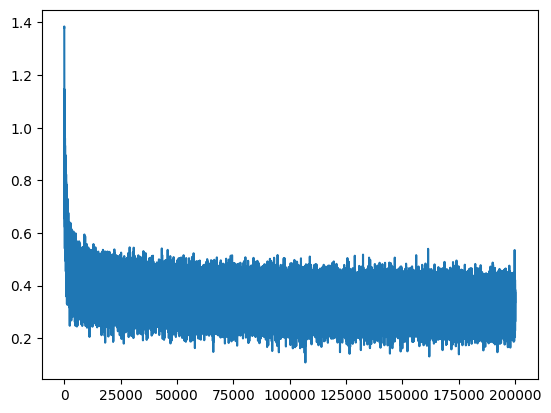

In [16]:
plt.plot(loss_x, loss_y)

In [17]:
def calc_loss(x, y):
    emb = C[x]
    h = (emb.view(-1, context_length * c_dim)@W1 + b1).tanh()
    logits = h@W2 + b2
    return F.cross_entropy(logits, y)

In [18]:
calc_loss(X_train, Y_train), calc_loss(X_valid, Y_valid), calc_loss(X_test, Y_test)

(tensor(2.1228, grad_fn=<NllLossBackward0>),
 tensor(2.1584, grad_fn=<NllLossBackward0>),
 tensor(2.1640, grad_fn=<NllLossBackward0>))

Let's visualize our embeddings lookup table (that's only possible when `c_dim` is `2`).

_Note how the vowels are clustered together and how the character `q` is isolated._

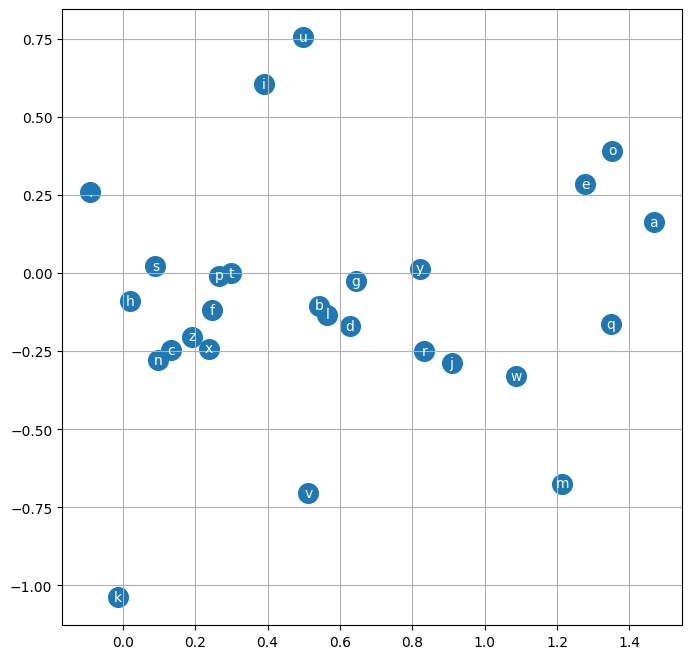

In [19]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itoc[i], ha="center", va="center", color="white")

plt.grid('minor')

Sampling words from the model:

In [20]:
for _ in range(20):

    output = []
    
    context = [0] * context_length

    while True:
        emb = C[context]
        h = (emb.view(-1, context_length * c_dim)@W1 + b1).tanh()
        logits = h@W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        output.append(ix)

        if ix == 0: break

    print(''.join(itoc[i] for i in output)) 

jamiance.
magaiga.
amorashri.
vihe.
zahideikahla.
anayla.
ros.
veth.
elmana.
eslani.
arie.
beika.
isrick.
peylon.
mattyta.
evel.
yemzia.
maela.
ellihua.
juhira.
